# Training a track-classification neural network on the data taken from cloud chamber using Keras

The aim of this project is to classify the cloud chamber track. The following program uses the technique of transfer learning to achieve our classification purpose. The base model used in the code is VGG-16, with a simple dense neural network as the classifier. The expected format of the image is PNG.

In [1]:
from os import environ
environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
np.random.seed(1234)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 8       # Training batch size
epochs      = 120       # Number of epochs
num_classes = 3        # Number of classes

# input image dimensions
img_rows, img_cols = 256, 256
vgg16_shape = 224      # Shape of VGG16 input image, (224X224X3)

mapping_csv = '../Data/mapping_all.csv'       # Name of the mapping.csv

## Read the data

The code below reads the dataset with the help of the mapping.csv file. The mapping.csv contains two columns, one is the image name and the other is the corresponding class ("alpha": 0, "beta": 1, "muon": 2).

In [3]:
from keras.utils.np_utils import to_categorical
import cv2

image_id, image_class = np.loadtxt(mapping_csv, delimiter=',', dtype={'names': ('image_id', 'image_class'),
          'formats': ('|S100', np.float)}, unpack=True)

#print image_id
X = []
for img_name in image_id:
    img = plt.imread('' + '../' + img_name)
    img = img[:,:,:3] # Drop out alpha channel of png
    X.append(img)
X = np.array(X)    # Convert list to array
y = image_class

# Convert digits to one-hot vectors, e.g.,
# 2 -> [0 0 1 0 0 0 0 0 0 0]
# 0 -> [1 0 0 0 0 0 0 0 0 0]
# 9 -> [0 0 0 0 0 0 0 0 0 1]
dummy_y = to_categorical(y)

Using TensorFlow backend.


Display some input images.

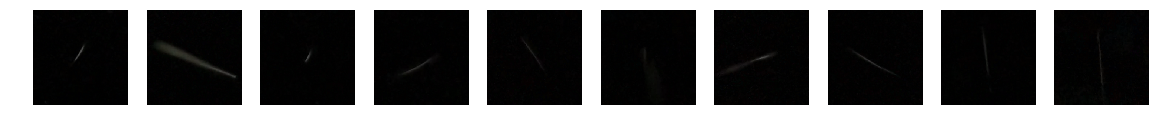

In [4]:
num_examples = 10
plt.figure(figsize=(num_examples*2, 2))
for i in range(num_examples):
    plt.subplot(1, num_examples, i+1)
    plt.axis('off')
    example = np.squeeze(np.array(X[i]*255).astype("uint8"))
    plt.imshow(example, cmap="gray")

Resize the image such that it fits the VGG16 input shape (224X224X3)

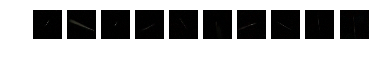

In [5]:
# Resize the input image to the VGG16 input image shape (224X224X3)
image = []
for i in range(0, X.shape[0]):
    a = np.squeeze(cv2.resize(X[i], (vgg16_shape, vgg16_shape), interpolation=cv2.INTER_LINEAR)*255).astype(int)
    #a = a[:,:,:3] # Drop out alpha channel of png
    image.append(a)
X = np.array(image)
for i in range(num_examples):
    plt.subplot(1, num_examples, i+1)
    plt.axis('off')
    example = X[i]
    plt.imshow(example, cmap="gray")

Preprocess the input and  split the data into training and validation set

In [6]:
from keras.applications.vgg16 import preprocess_input
X = preprocess_input(X, mode='tf')      # preprocessing the input data
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
dummy_y = dummy_y[indices]

test_size = 0.9
split = int(test_size * len(X))
X_train = X[:split]
X_test = X[split:]
y_train = dummy_y[:split]
y_test = dummy_y[split:]

## Define the model

Transfer Learning is used to improve the classification power of the neural network. The base model is VGG-16, which is a model of the 16-layer network used by the VGG team in the ILSVRC-2014 competition. More information can be found on https://keras.io/applications/#vgg16.

In [7]:
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import InputLayer, Dense, Dropout, Flatten, MaxPooling2D, Conv2D
from keras.optimizers import Adam
from keras import regularizers

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(vgg16_shape, vgg16_shape, 3))    # include_top=False to remove the top layer

X_train = base_model.predict(X_train)
X_test = base_model.predict(X_test)
X_train.shape, X_test.shape

model_inputshape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]

X_train = X_train.reshape(X_train.shape[0], model_inputshape) # Converting to 1-D
X_test = X_test.reshape(X_test.shape[0], model_inputshape)

train = X_train/X_train.max()      # centering the data
X_test = X_test/X_train.max()
#train = X_train

The output from the pre-trained model is fed to our own neural network. L2 regularization and dropout layer are used to prevent overfitting.

In [8]:
model = Sequential()
model.add(InputLayer((model_inputshape,)))    # input layer
model.add(Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))   # hidden layer
model.add(Dropout(0.25))      # adding dropout
model.add(Dense(units=32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))    # hidden layer
model.add(Dropout(0.25))      # adding dropout
model.add(Dense(units=16, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))    # hidden layer
model.add(Dropout(0.5))      # adding dropout
model.add(Dense(num_classes, activation='softmax'))    # output layer

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1605696   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 51        
Total para

## Compile the model

Using Keras, you have to `compile` a model, which means adding the loss function, the optimizer algorithm and validation metrics to your training setup.

In [9]:
model.compile(loss="categorical_crossentropy",
        optimizer=Adam(lr=lr_init),
        metrics=["accuracy"])

## Train the model

The cell below shows the training procedure of Keras using the `model.fit(...)` method. Besides typical options such as `batch_size` and `epochs`, which control the number of gradient steps of your training, Keras allows to use callbacks during training.

Callbacks are methods, which are called during training to perform tasks such as saving checkpoints of the model (`ModelCheckpoint`) or stop the training early if a convergence criteria is met (`EarlyStopping`).

In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
            filepath="ccAI_model.h5",
            save_best_only=True,
            verbose=1)
early_stopping = EarlyStopping(patience=50)

history = model.fit(train, y_train, # Training data
            batch_size=batch_size, # Batch size
            epochs=epochs, # Maximum number of training epochs
            validation_split=0.5, # Use 50% of the train dataset for validation
            callbacks=[checkpoint, early_stopping]) # Register callbacks

Train on 748 samples, validate on 748 samples
Epoch 1/120
748/748 [==============================] - 2s 2ms/step - loss: 0.9901 - acc: 0.5160 - val_loss: 0.8735 - val_acc: 0.5668

Epoch 00001: val_loss improved from inf to 0.87350, saving model to ccAI_model.h5
Epoch 2/120
748/748 [==============================] - 1s 1ms/step - loss: 0.8400 - acc: 0.6176 - val_loss: 0.7623 - val_acc: 0.5668

Epoch 00002: val_loss improved from 0.87350 to 0.76232, saving model to ccAI_model.h5
Epoch 3/120
748/748 [==============================] - 1s 1ms/step - loss: 0.7506 - acc: 0.6952 - val_loss: 0.6664 - val_acc: 0.8061

Epoch 00003: val_loss improved from 0.76232 to 0.66639, saving model to ccAI_model.h5
Epoch 4/120
748/748 [==============================] - 1s 1ms/step - loss: 0.6709 - acc: 0.7807 - val_loss: 0.6748 - val_acc: 0.6898

Epoch 00004: val_loss did not improve from 0.66639
Epoch 5/120
748/748 [==============================] - 1s 1ms/step - loss: 0.6205 - acc: 0.7901 - val_loss: 0.533

748/748 [==============================] - 1s 1ms/step - loss: 0.4590 - acc: 0.8356 - val_loss: 0.4279 - val_acc: 0.8369

Epoch 00042: val_loss did not improve from 0.42449
Epoch 43/120
748/748 [==============================] - 1s 2ms/step - loss: 0.4262 - acc: 0.8436 - val_loss: 0.4559 - val_acc: 0.8302

Epoch 00043: val_loss did not improve from 0.42449
Epoch 44/120
748/748 [==============================] - 1s 1ms/step - loss: 0.4412 - acc: 0.8409 - val_loss: 0.4257 - val_acc: 0.8356

Epoch 00044: val_loss did not improve from 0.42449
Epoch 45/120
748/748 [==============================] - 1s 1ms/step - loss: 0.4245 - acc: 0.8489 - val_loss: 0.4891 - val_acc: 0.8142

Epoch 00045: val_loss did not improve from 0.42449
Epoch 46/120
748/748 [==============================] - 1s 1ms/step - loss: 0.4420 - acc: 0.8436 - val_loss: 0.4294 - val_acc: 0.8342

Epoch 00046: val_loss did not improve from 0.42449
Epoch 47/120
748/748 [==============================] - 1s 1ms/step - loss: 0.5120 

748/748 [==============================] - 1s 2ms/step - loss: 0.4210 - acc: 0.8463 - val_loss: 0.4418 - val_acc: 0.8396

Epoch 00086: val_loss did not improve from 0.41957
Epoch 87/120
748/748 [==============================] - 1s 1ms/step - loss: 0.4299 - acc: 0.8436 - val_loss: 0.4567 - val_acc: 0.8289

Epoch 00087: val_loss did not improve from 0.41957
Epoch 88/120
748/748 [==============================] - 1s 1ms/step - loss: 0.4422 - acc: 0.8342 - val_loss: 0.4399 - val_acc: 0.8382

Epoch 00088: val_loss did not improve from 0.41957
Epoch 89/120
748/748 [==============================] - 1s 1ms/step - loss: 0.4203 - acc: 0.8449 - val_loss: 0.4357 - val_acc: 0.8369

Epoch 00089: val_loss did not improve from 0.41957
Epoch 90/120
748/748 [==============================] - 1s 2ms/step - loss: 0.4530 - acc: 0.8302 - val_loss: 0.4596 - val_acc: 0.8409

Epoch 00090: val_loss did not improve from 0.41957
Epoch 91/120
748/748 [==============================] - 1s 1ms/step - loss: 0.4245 

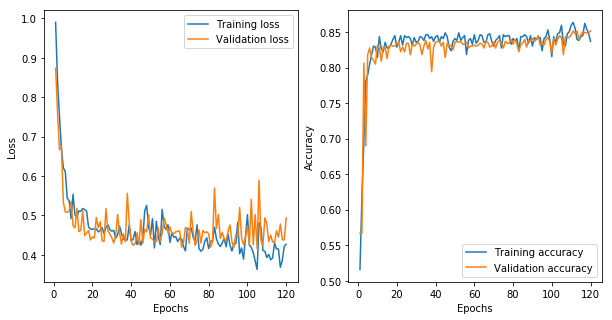

In [11]:
epochs = range(1, len(history.history["loss"])+1)
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["loss"], label="Training loss")
plt.plot(epochs, history.history["val_loss"], label="Validation loss")
plt.legend(), plt.xlabel("Epochs"), plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["acc"], label="Training accuracy")
plt.plot(epochs, history.history["val_acc"], label="Validation accuracy")
plt.legend(), plt.xlabel("Epochs"), plt.ylabel("Accuracy");

## Test the model

The prediction of unseen data is performed using the `model.predict(inputs)` call. Below, a basic test of the model is done by calculating the accuracy on the test dataset.

In [12]:
# Get predictions on test dataset
y_pred = model.predict(X_test)

# Compare predictions with ground truth
test_accuracy = np.sum(
        np.argmax(y_test, axis=1)==np.argmax(y_pred, axis=1))/float(X_test.shape[0])

print("Test accuracy: {}".format(test_accuracy))

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test accuracy: 0.874251497006
('Test loss:', 0.47283156064456094)
('Test accuracy:', 0.874251497005988)
